In [ ]:
import numpy as np
import scipy as sp
import networkx as nx
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from numpy.linalg import norm
from math import ceil
from matplotlib import cm
import scipy.optimize
from scipy.special import expit as sigmoid, logit as logit
from scipy.sparse import csr_matrix

SECTION 1 : UTILITY FUNCTIONS

1.  sample_adjacency_from_probs() : Used to sample a random adjacency matrix from a matrix which contains values which a are probabilities that a specific edge exists in the graph.
2.  analyze_graph(): Prints varius stats for a graph
3. Interpretability plotter


In [ ]:
# -----------------------------
# Adjacency Sampling from Probabilities
# -----------------------------
def sample_adjacency_from_probs(P):
    """
    Vectorized version: Given a symmetric matrix P where P[i,j] is the probability
    of an edge between i and j, sample a symmetric binary adjacency matrix A.
    """
    n = P.shape[0]
    upper_tri_indices = np.triu_indices(n, 1)
    random_matrix = np.random.rand(len(upper_tri_indices[0]))
    A = np.zeros((n, n), dtype=int)
    A[upper_tri_indices] = (random_matrix < P[upper_tri_indices]).astype(int)
    A = A + A.T
    return A

In [ ]:
#---------------------------
#ANALYSE GRAPH FOR DIFFERENT PARAMETERS
#---------------------------
def analyze_graph(adj):
    G = nx.from_numpy_array(A)
    num_edges = G.number_of_edges()
    num_nodes = G.number_of_nodes()
    degrees = np.array([deg for _, deg in G.degree()])
    max_degree = int(degrees.max())
    avg_degree = degrees.mean()
    num_triangles = int(np.trace(A @ A @ A) // 6)
    arboricity = 0
    for sub_nodes in nx.connected_components(G):
        H = G.subgraph(sub_nodes)
        v = H.number_of_nodes()
        e = H.number_of_edges()
        if v > 1:
            arboricity = max(arboricity, ceil(e / (v - 1)))
    print(f"Number of nodes:{num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Number of triangles: {num_triangles}")
    print(f"Maximum degree: {max_degree}")
    print(f"Average degree: {avg_degree:.2f}")
    print(f"Arboricity : {arboricity}")


In [ ]:
def plot_softmax_distributions(adj, B, C):
    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    def plot_softmax_stats(matrix, label):
        probs = softmax(matrix)
        max_probs = np.max(probs, axis=1)
        sorted_probs = np.sort(probs, axis=1)
        second_max_probs = sorted_probs[:, -2]
        predicted_classes = np.argmax(probs, axis=1)

        plt.figure(figsize=(12, 4))
        scatter = plt.scatter(np.arange(len(max_probs)), max_probs, c=predicted_classes, cmap='tab10', s=10, label='Max')
        plt.scatter(np.arange(len(second_max_probs)), second_max_probs, c='gray', s=10, alpha=0.5, label='2nd Max')
        plt.colorbar(scatter, label='Predicted class')
        plt.xlabel('Node index')
        plt.ylabel('Softmax Probability')
        plt.title(f'Max and 2nd Max Softmax Probabilities ({label})')
        plt.ylim(0, 1.05)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # --- Plot adjacency matrix ---
    plt.figure(figsize=(6, 6))
    plt.title("Input Adjacency Matrix")
    plt.imshow(adj.toarray(), cmap='Greens', interpolation='none')
    plt.colorbar(label='Edge')
    plt.tight_layout()
    plt.show()

    # --- Plot softmax stats for B and C ---
    plot_softmax_stats(B, 'B')
    plot_softmax_stats(C, 'C')


Section 2 : Graph Generators

In [ ]:
# -----------------------------
# G1 : Deterministic graph have n/3 triangles for n nodes, we make a cycle of the triangles.
# -----------------------------
def create_triangle_cycle(num_triangles):
    G = nx.Graph()
    node_counter = 0
    triangle_nodes = []
    for i in range(num_triangles):
        a, b, c = node_counter, node_counter + 1, node_counter + 2
        G.add_edges_from([(a, b), (b, c), (c, a)])
        if i > 0:
            G.add_edge(triangle_nodes[-1][2], a)
        triangle_nodes.append((a, b, c))
        node_counter += 3
    G.add_edge(triangle_nodes[-1][2], triangle_nodes[0][0])
    adj = nx.to_numpy_array(G)
    return adj

In [ ]:
# -----------------------------
# G2 : Random Sparse trainagular graph where we randomly make arounf 2*n triangles for n nodes
# -----------------------------
def create_sparse_triangle_graph(num_nodes, triangles_per_node=2):
    import random
    G = nx.Graph()
    for i in range(num_nodes):
        for _ in range(triangles_per_node):
            # Pick two random neighbors to form a triangle
            j = random.randint(0, num_nodes - 1)
            k = random.randint(0, num_nodes - 1)
            if i != j and i != k and j != k:
                G.add_edges_from([(i, j), (j, k), (k, i)])
    return nx.to_numpy_array(G)

In [ ]:
# -----------------------------
# G3 : Stoichastic Block Matrix used to have just homophilic communities.
# -----------------------------
def create_sbm(sizes, p_in, p_out):
    probs = [[p_in if i == j else p_out for j in range(len(sizes))] for i in range(len(sizes))]
    return nx.to_numpy_array(nx.stochastic_block_model(sizes, probs, seed=42))

In [ ]:
# -----------------------------
# G4 : Has both Homophilic and Heterophilic interaction.
# -----------------------------
def make_het_hom_graph(n, het_probs, hom_probs):
    num_het = len(het_probs)
    num_hom = len(hom_probs)
    U = np.zeros((n, num_het+num_hom))
    hets = np.random.choice(num_het, p=het_probs, size=n)
    homs = np.random.choice(num_hom, p=hom_probs, size=n)
    vals = homs*num_het + hets
    perm = np.argsort(vals)
    hets = hets[perm]
    homs = homs[perm]
    U[np.arange(n), homs] = 1
    U[np.arange(n), hets+num_hom] = 1
    U = np.hstack([np.ones(n)[:,None], U])

    W = 5*np.diag(np.concatenate(([-0.5], np.ones(num_hom), -1*np.ones(num_het))))
    return sample_adjacency_from_probs(sigmoid(U @ W @ U.T))

In [ ]:
#---------------------------
# G5: k-clique
#---------------------------

def generate_clique(k):
    """
    Generates a k-clique (complete graph) adjacency matrix as a dense NumPy array.
    """
    G = nx.complete_graph(k)
    adj = nx.to_numpy_array(G)
    np.fill_diagonal(adj, 0)
    return adj

In [ ]:
#----------------------------------------------------------
# G6: n disconnedcted cliques of size k each
#----------------------------------------------------------
def generate_disconnected_cliques(n, k):
    """
    Generate a graph with n disconnected cliques, each of size k.
    Returns the adjacency matrix as a NumPy array.
    """
    G = nx.Graph()
    for i in range(n):
        clique_nodes = range(i * k, (i + 1) * k)
        G.add_edges_from((u, v) for u in clique_nodes for v in clique_nodes if u != v)
    adj = nx.to_numpy_array(G)
    return adj

SECTION 2 : Low Dimention Embedding Methods

1.  SVD
2.  LPCA
3.  BIGCLAM
4.  DSNE
5.  AR Decomposition
6.  LPCA TO
7.  Hinge Loss Based
8.  Interpretable Version

In [ ]:
# -----------------------------
# SVD to get low rank approximation
# -----------------------------

def svd(A, rank):
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    X= U[:, :rank] @ np.diag(S[:rank]) @ Vt[:rank, :]
    np.fill_diagonal(X,0)
    return X


In [ ]:
# -----------------------------
# LPCA Function
# -----------------------------


def lpca(A, rank, max_iter=500,return_feats=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(f"Using device: {device}")

    A_tensor = torch.tensor(A, dtype=torch.float32, device=device)
    A_tilde = 2 * A_tensor - 1  # Convert to {-1, 1}

    n_row, n_col = A_tensor.shape

    U = torch.randn(n_row, rank, device=device, requires_grad=True)
    V = torch.randn(rank, n_col, device=device, requires_grad=True)

    optimizer = torch.optim.LBFGS([U, V], max_iter=max_iter)

    def closure():
        optimizer.zero_grad()
        logits = U @ V
        loss = F.softplus(-logits * A_tilde).sum()
        loss.backward()
        return loss

    optimizer.step(closure)

    with torch.no_grad():
        logits = U @ V
        A_lpca = torch.sigmoid(logits).cpu().numpy()
    if return_feats:
      return A_lpca,U,V.T
    else:
      return A_lpca

In [ ]:
#-----------------------------
# BIGCLAM
#-----------------------------
def get_bigclam_approx(adj, rank, loss_iters=100, reg_l2=0., reg_l1=0., eps=1e-8,
                       adj_mask=None,
                       return_factors=False, verbose=False):
    def bigclam_loss(X, adj, n, rank, adj_mask, loss_ew_wgt):
        X = torch.tensor(X.reshape(n, rank), requires_grad=True)
        adj_recon = 1. - torch.exp(-X @ X.T)
        adj_recon = torch.clamp(adj_recon, min=eps, max=1.-eps)

        if adj_mask is None:
            loss_ew = -torch.log(torch.where(adj==1,adj_recon,1.-adj_recon)).sum()
        else:
            loss_ew = -(adj_mask * torch.log(torch.where(adj==1,adj_recon,1.-adj_recon))).sum() * loss_ew_wgt

        loss_reg = torch.tensor(0.)
        if reg_l2 > 0:
            loss_reg += X.pow(2).sum() * reg_l2
        if reg_l1 > 0:
            loss_reg += torch.abs(X).sum() * reg_l1

        loss = loss_ew + loss_reg
        loss.backward()
        if verbose:
            print([tens.detach().numpy() for tens in [loss, loss_ew, loss_reg]])
        return loss.detach().numpy(), X.grad.numpy().flatten()

    n = adj.shape[0]
    factors = ((-np.log(1 - (adj.sum() / (n*n)))) + np.sqrt(eps)*np.random.random(size=(n*rank))) / np.sqrt(rank)

    if adj_mask is None:
        loss_ew_wgt = 1.
    else:
        loss_ew_wgt = (n**2) / adj_mask.sum()

    res = scipy.optimize.minimize(bigclam_loss, x0=factors,
                                  args=(torch.tensor(np.array(adj.todense())), n, rank,
                                        adj_mask, loss_ew_wgt),
                                  jac=True, method='L-BFGS-B',
                                  bounds = [(0.,None)]*n*rank,
                                  tol=np.finfo(float).eps,
                                  options={'maxiter':loss_iters, 'ftol':np.finfo(float).eps, 'gtol':np.finfo(float).eps}
                                 )
    factors = res.x
    X = res.x.reshape(n, rank)
    adj_recon = np.clip(1. - np.exp(-X @ X.T), a_min=eps, a_max=1.-eps)
    if return_factors:
        return adj_recon, X
    else:
        return adj_recon


In [ ]:
#----------------------------------
# DSNE (MAIN METHOD)
#---------------------------------
def DSNE(adj, B_rank, C_rank, loss_iters=100, reg_l2=0., reg_l1=0.,
                  eps=1e-8, base_logit=True,
                  adj_mask=None,
                  return_factors=False, verbose=False):
    def bc_loss(factors, adj, n, B_rank, C_rank, base_logit, adj_mask, loss_ew_wgt):
        B = torch.tensor(factors[:n*B_rank].reshape(n, B_rank), requires_grad=True)
        C = torch.tensor(factors[n*B_rank:].reshape(n, C_rank), requires_grad=True)
        logits = base_logit + B @ B.T - C @ C.T
        logits = torch.clamp(logits, min=logit(eps), max=-logit(eps))
        if adj_mask is None:
            loss_ew = -torch.nn.functional.logsigmoid(torch.where(adj==1,+1,-1)*logits).sum() # entrywise CE loss
        else:
            loss_ew = -(adj_mask * torch.nn.functional.logsigmoid(torch.where(adj==1,+1,-1)*logits)).sum() * loss_ew_wgt
        loss_reg = 0
        if reg_l2 > 0:
            loss_reg += (B.pow(2).sum() + C.pow(2).sum()) / 2. * reg_l2
        if reg_l1 > 0:
            loss_reg += (torch.abs(B).sum() + torch.abs(C).sum()) / 2. * reg_l1
        loss = loss_ew + loss_reg
        loss.backward()
        if verbose:
            print([tens.detach().numpy() for tens in [loss, loss_ew, loss_reg]])
        return loss.detach().numpy(), np.concatenate((B.grad.numpy().flatten(), C.grad.numpy().flatten()))

    n = adj.shape[0]
    if base_logit:
        base_logit = logit(adj.sum() / (n*n))
    else:
        base_logit = 0.
    factors = 1. * np.concatenate([(np.random.random(size=(n*B_rank))) / np.sqrt(B_rank),
                                   (np.random.random(size=(n*C_rank))) / np.sqrt(C_rank)])

    if adj_mask is None:
        loss_ew_wgt = 1.
    else:
        loss_ew_wgt = (n**2) / adj_mask.sum()

    res = scipy.optimize.minimize(bc_loss, x0=factors,
                                  args=(torch.tensor(np.array(adj.todense())), n, B_rank, C_rank, base_logit,
                                        adj_mask, loss_ew_wgt),
                                  jac=True, method='L-BFGS-B',
                                  bounds = [(0.,None)]*n*(B_rank+C_rank),
                                  tol=np.finfo(float).eps,
                                  options={'maxiter':loss_iters, 'ftol':np.finfo(float).eps, 'gtol':np.finfo(float).eps}
                                 )
    factors = res.x
    B = res.x[:n*B_rank].reshape(n, B_rank)
    C = res.x[n*B_rank:].reshape(n, C_rank)
    logits = base_logit + B @ B.T - C @ C.T
    adj_recon = np.clip(sigmoid(logits), a_min=eps, a_max=1.-eps)
    if return_factors:
        return adj_recon, B, C, base_logit
    else:
        return adj_recon

In [ ]:
#-----------------------------
# AR-DEcomposition
#-----------------------------
def minimal_ar_decomposition(adj, k=None, loss_iters=1000, eps=1e-8, return_factors=False, verbose=False)
    def ar_loss(diag, adj_tensor, n):
        diag_t = torch.tensor(diag, dtype=torch.float32, requires_grad=True)
        M = adj_tensor.clone()
        M[range(n), range(n)] = diag_t
        S = torch.linalg.svdvals(M)
        loss = S.sum()
        loss.backward()
        return loss.item(), diag_t.grad.numpy()

    n = adj.shape[0]
    adj_tensor = torch.tensor(np.array(adj.todense()), dtype=torch.float32)

    # True initial rank of the unmodified adjacency matrix
    A_rank = np.linalg.matrix_rank(adj.toarray())
    # print(f"Original adjacency matrix rank: {A_rank}")

    x0 = np.ones(n)
    result = scipy.optimize.minimize(
        ar_loss,
        x0,
        args=(adj_tensor, n),
        jac=True,
        method="L-BFGS-B",
        options={'maxiter': loss_iters}
    )

    diag_opt = result.x
    M = adj_tensor.clone()
    M[range(n), range(n)] = torch.tensor(diag_opt, dtype=torch.float32)

    # Rank after perturbing the diagonal
    M_np = M.detach().numpy()
    eigvals, eigvecs = np.linalg.eigh(M_np)
    perturbed_rank = np.sum(np.abs(eigvals) > eps)
    # print(f"Rank after diagonal optimization (before truncation): {perturbed_rank}")

    # Truncate to k eigenvalues if specified
    if k is not None:
        idx = np.argsort(np.abs(eigvals))
        eigvals[idx[:len(eigvals) - k]] = 0
    truncated_rank = np.sum(np.abs(eigvals) > eps)
    # Decomposition
    D_pos_idx = eigvals > 0
    D_neg_idx = eigvals < 0
    D_pos = np.diag(eigvals[D_pos_idx])
    D_neg = np.diag(-eigvals[D_neg_idx])

    Q_pos = eigvecs[:, D_pos_idx]
    Q_neg = eigvecs[:, D_neg_idx]

    A = Q_pos @ np.sqrt(D_pos)
    R = Q_neg @ np.sqrt(D_neg)

    adj_recon = A @ A.T - R @ R.T
    np.fill_diagonal(adj_recon, 0)

    if return_factors:
        return adj_recon, A, R
    else:
        return adj_recon


In [ ]:
#---------------------------------
# LPCA to DSNE
#---------------------------------

def lpca_to_community_factors(X, Y):
    """
    Implements Algorithm 1 from the paper: Converts LPCA factors to community factors B, C.

    Parameters:
    - X, Y: (n x k) torch tensors

    Returns:
    - B, C: nonnegative torch tensors with shape (n x kB), (n x kC)
    """
    n, k = X.shape
    S = 0.5 * (X @ Y.T + Y @ X.T)
    eigenvalues, eigenvectors = torch.linalg.eigh(S)

    sqrt_eigs = torch.sqrt(torch.abs(eigenvalues))
    Q_plus = eigenvectors[:, eigenvalues > 0]
    lambda_plus = sqrt_eigs[eigenvalues > 0]

    Q_minus = eigenvectors[:, eigenvalues < 0]
    lambda_minus = sqrt_eigs[eigenvalues < 0]

    B_star = Q_plus @ torch.diag(lambda_plus)
    C_star = Q_minus @ torch.diag(lambda_minus)

    relu = torch.nn.functional.relu
    abs_fn = torch.abs

    B = torch.cat([torch.sqrt(torch.tensor(2.0)) * relu(B_star),
                   torch.sqrt(torch.tensor(2.0)) * relu(-B_star),
                   abs_fn(C_star)], dim=1)

    C = torch.cat([torch.sqrt(torch.tensor(2.0)) * relu(C_star),
                   torch.sqrt(torch.tensor(2.0)) * relu(-C_star),
                   abs_fn(B_star)], dim=1)
    with torch.no_grad():
        logits = B @ B.T - C @ C.T
        ret = torch.sigmoid(logits).cpu().numpy()
        B_np = B.cpu().numpy()
        C_np = C.cpu().numpy()

    return ret, B_np, C_np


In [ ]:
def hinge_base(adj, B_rank, C_rank, loss_iters=100, reg_l2=0., reg_l1=0.,
                  eps=1e-8, base_logit=True,
                  adj_mask=None,
                  return_factors=False, verbose=False):
    def bc_loss(factors, adj, n, B_rank, C_rank, base_logit, adj_mask, loss_ew_wgt):
      B = torch.tensor(factors[:n*B_rank].reshape(n, B_rank), requires_grad=True)
      C = torch.tensor(factors[n*B_rank:].reshape(n, C_rank), requires_grad=True)

      scores = base_logit + B @ B.T - C @ C.T  # linear scores
      labels = 2 * (adj.float() > 0) - 1       # convert {0,1} to {-1,+1}

      hinge = torch.clamp(1. - labels * scores, min=0)  # max(0, 1 - y*s)

      if adj_mask is None:
          loss_ew = hinge.sum()
      else:
          loss_ew = (adj_mask * hinge).sum() * loss_ew_wgt

      loss_reg = 0
      if reg_l2 > 0:
          B_over = torch.clamp(B - 1, min=0)
          B_under = torch.clamp(-B, min=0)
          C_over = torch.clamp(C - 1, min=0)
          C_under = torch.clamp(-C, min=0)

          penalty = (B_over.pow(2).sum() + B_under.pow(2).sum() +
               C_over.pow(2).sum() + C_under.pow(2).sum())

          loss_reg += penalty * reg_l2
      if reg_l1 > 0:
          loss_reg += (torch.abs(B).sum() + torch.abs(C).sum()) / 2. * reg_l1

      loss = loss_ew + loss_reg
      loss.backward()

      if verbose:
          print([tens.detach().numpy() for tens in [loss, loss_ew, loss_reg]])

      return loss.detach().numpy(), np.concatenate((B.grad.numpy().flatten(), C.grad.numpy().flatten()))


    n = adj.shape[0]
    adj_dense = torch.tensor(np.array(adj.todense()))
    negative_sample_ratio=1.0
    if base_logit: # adjusts baseline probability of edge
        base_logit = logit(adj.sum() / (n*n))
    else:
        base_logit = 0.
    factors = 1. * np.concatenate([(np.random.random(size=(n*B_rank))) / np.sqrt(B_rank),
                                   (np.random.random(size=(n*C_rank))) / np.sqrt(C_rank)])

    if adj_mask is None:
        pos_idx = (adj_dense > 0).nonzero(as_tuple=False)
        num_pos = pos_idx.shape[0]
        num_neg = int(num_pos * negative_sample_ratio)

        all_idx = torch.cartesian_prod(torch.arange(n), torch.arange(n))
        neg_idx = all_idx[(adj_dense == 0).view(-1)]
        sampled_neg_idx = neg_idx[torch.randperm(neg_idx.shape[0])[:num_neg]]

        mask = torch.zeros((n, n))
        mask[pos_idx[:, 0], pos_idx[:, 1]] = 1
        mask[sampled_neg_idx[:, 0], sampled_neg_idx[:, 1]] = 1
        adj_mask = mask
        loss_ew_wgt = (n * n) / adj_mask.sum()
    else:
        loss_ew_wgt = (n * n) / adj_mask.sum()


    res = scipy.optimize.minimize(bc_loss, x0=factors,
                                  args=(torch.tensor(np.array(adj.todense())), n, B_rank, C_rank, base_logit,
                                        adj_mask, loss_ew_wgt),
                                  jac=True, method='L-BFGS-B',
                                  bounds = [(0.,None)]*n*(B_rank+C_rank),
                                  tol=np.finfo(float).eps,
                                  options={'maxiter':loss_iters, 'ftol':np.finfo(float).eps, 'gtol':np.finfo(float).eps}
                                 )
    factors = res.x
    B = res.x[:n*B_rank].reshape(n, B_rank)
    C = res.x[n*B_rank:].reshape(n, C_rank)
    logits = base_logit + B @ B.T - C @ C.T
    adj_recon = logits
    if return_factors:
        return adj_recon, B, C, base_logit
    else:
        return adj_recon

In [ ]:
def interpretable(adj, B_rank, C_rank, loss_iters=100, reg_l2=0., reg_l1=0.,
                  eps=1e-8, base_logit=True,
                  adj_mask=None,
                  return_factors=False, verbose=False):
    def bc_loss(factors, adj, n, B_rank, C_rank, base_logit, adj_mask, loss_ew_wgt):
      B_raw = torch.tensor(factors[:n*B_rank].reshape(n, B_rank), requires_grad=True)
      C_raw = torch.tensor(factors[n*B_rank:].reshape(n, C_rank), requires_grad=True)

      B_raw.retain_grad()
      C_raw.retain_grad()

      B = F.softmax(B_raw, dim=1)
      C = F.softmax(C_raw, dim=1)


      logits = base_logit + B @ B.T - C @ C.T

      if adj_mask is None:
        loss_ew = ((logits - adj.float()) ** 2).sum()
      else:
        loss_ew = ((adj_mask * (logits - adj.float()) ** 2)).sum() * loss_ew_wgt
      loss_reg = 0
      if reg_l2 > 0:
          loss_reg += (B.pow(2).sum() + C.pow(2).sum()) / 2. * reg_l2
      if reg_l1 > 0:
          loss_reg += (torch.abs(B).sum() + torch.abs(C).sum()) / 2. * reg_l1

      loss = loss_ew + loss_reg
      loss.backward()

      if verbose:
          print([tens.detach().numpy() for tens in [loss, loss_ew, loss_reg]])

      return loss.detach().numpy(), np.concatenate((B_raw.grad.numpy().flatten(), C_raw.grad.numpy().flatten()))


    n = adj.shape[0]
    if base_logit: # adjusts baseline probability of edge
        base_logit = logit(adj.sum() / (n*n))
    else:
        base_logit = 0.
    factors = 1. * np.concatenate([(np.random.random(size=(n*B_rank))) / np.sqrt(B_rank),
                                   (np.random.random(size=(n*C_rank))) / np.sqrt(C_rank)])

    if adj_mask is None:
        loss_ew_wgt = 1.
    else:
        loss_ew_wgt = (n**2) / adj_mask.sum()

    res = scipy.optimize.minimize(bc_loss, x0=factors,
                                  args=(torch.tensor(np.array(adj.todense())), n, B_rank, C_rank, base_logit,
                                        adj_mask, loss_ew_wgt),
                                  jac=True, method='L-BFGS-B',
                                  bounds = [(0.,None)]*n*(B_rank+C_rank),
                                  tol=np.finfo(float).eps,
                                  options={'maxiter':loss_iters, 'ftol':np.finfo(float).eps, 'gtol':np.finfo(float).eps}
                                 )
    factors = res.x
    B_raw = torch.tensor(res.x[:n*B_rank].reshape(n, B_rank), dtype=torch.float32)
    C_raw = torch.tensor(res.x[n*B_rank:].reshape(n, C_rank), dtype=torch.float32)
    B = F.softmax(B_raw, dim=1)
    C = F.softmax(C_raw, dim=1)
    logits = base_logit + B @ B.T - C @ C.T
    adj_recon = logits.detach().numpy()
    if return_factors:
        return adj_recon, B, C, base_logit
    else:
        return adj_recon

Experiment 1: SVD vs LPCA for sparse highly triangulated graph of type G1

Number of nodes:2000
Number of edges: 11967
Number of triangles: 4230
Maximum degree: 28
Average degree: 11.97
Arboricity : 6
Rank: 2, LPCA Error: 1.4037755438655222, SVD Error: 0.9947837952985016
Rank: 4, LPCA Error: 1.390707981171626, SVD Error: 0.9918098495245711
Rank: 6, LPCA Error: 1.3583657521093935, SVD Error: 0.9887387110828946
Rank: 8, LPCA Error: 1.3050608243783697, SVD Error: 0.985663163156249
Rank: 10, LPCA Error: 1.2426435994417542, SVD Error: 0.9825993109404189
Rank: 12, LPCA Error: 1.178198093654047, SVD Error: 0.9795459066991237
Rank: 14, LPCA Error: 1.0984389205463223, SVD Error: 0.9765113066021254
Rank: 16, LPCA Error: 0.9681999866620054, SVD Error: 0.973432027489418
Rank: 18, LPCA Error: 0.8448646477894048, SVD Error: 0.9704073924391508
Rank: 20, LPCA Error: 0.7161193620854972, SVD Error: 0.9674427109348882
Rank: 22, LPCA Error: 0.530746001200754, SVD Error: 0.9644821749351027
Rank: 24, LPCA Error: 0.3924370677915372, SVD Error: 0.961548736610278
Rank: 26, LPCA Error

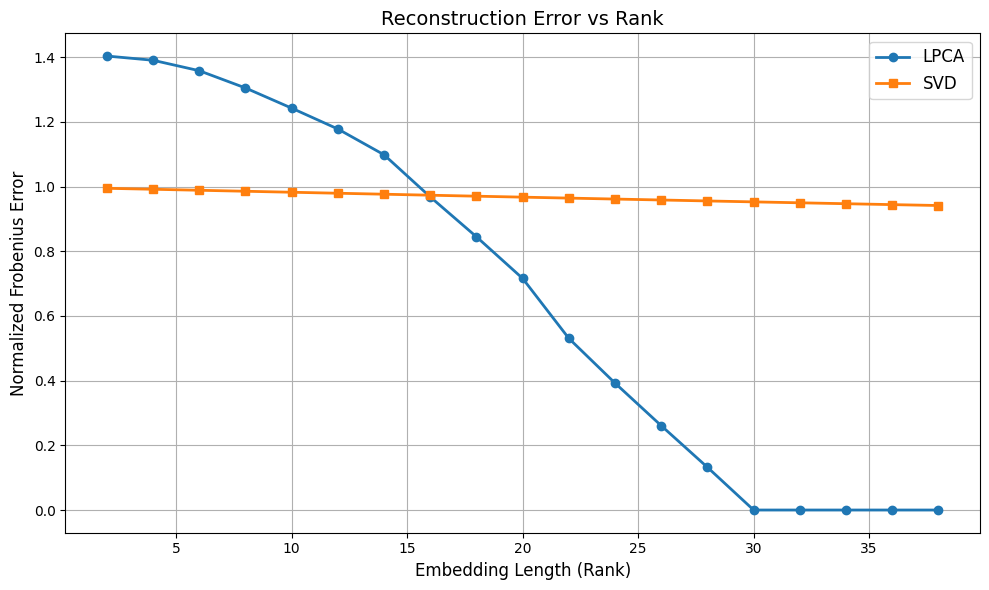

In [ ]:
ranks = list(range(2, 40 , 2))
err_list_lpca = []
err_list_svd = []
A = create_sparse_triangle_graph(2000).astype(float)
eps = 1e-8
analyze_graph(A)

denom=norm(A, ord='fro')
for rank in ranks:
    # --- LPCA ---
    if rank>2 and err_list_lpca[-1]==0.:
      err_list_lpca.append(0.)
    else:
      P_lpca = lpca(A, rank)
      np.fill_diagonal(P_lpca, 0.)
      A_sampled_lpca = sample_adjacency_from_probs(P_lpca)
      err = norm(A_sampled_lpca - A, ord='fro') / denom
      err_list_lpca.append(err)

    # --- SVD ---
    X=np.clip(svd(A, rank),0.,1.)
    np.fill_diagonal(X, 0.)
    # P_svd = np.clip(svd(A, rank),eps,1.-eps)
    # A_sampled_svd = sample_adjacency_from_probs(P_svd)
    err = norm(X - A, ord='fro') / denom
    err_list_svd.append(err)
    print(f"Rank: {rank}, LPCA Error: {err_list_lpca[-1]}, SVD Error: {err_list_svd[-1]}")

# --- Plotting ---

plt.figure(figsize=(10, 6))
plt.plot(ranks, err_list_lpca, marker='o', label='LPCA', linewidth=2)
plt.plot(ranks, err_list_svd, marker='s', label='SVD', linewidth=2)
plt.title('Reconstruction Error vs Rank', fontsize=14)
plt.xlabel('Embedding Length (Rank)', fontsize=12)
plt.ylabel('Normalized Frobenius Error', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


Experiment 2: SVD vs LPCA for sparse highly triangulated graph of type G2

Number of nodes:3000
Number of edges: 4000
Number of triangles: 1000
Maximum degree: 3
Average degree: 2.67
Arboricity : 2
Rank: 2, LPCA Error: 1.3958868148958208, SVD Error: 0.9990392499038826
Rank: 4, LPCA Error: 1.0861629711972325, SVD Error: 0.9980125931812397
Rank: 6, LPCA Error: 0.2889636655359978, SVD Error: 0.9970099594028932
Rank: 8, LPCA Error: 0.03872983346207416, SVD Error: 0.9960062507958991
Rank: 10, LPCA Error: 0.0, SVD Error: 0.9949995844745461
Rank: 12, LPCA Error: 0.0, SVD Error: 0.9939910022928385
Rank: 14, LPCA Error: 0.0, SVD Error: 0.9929806074651586


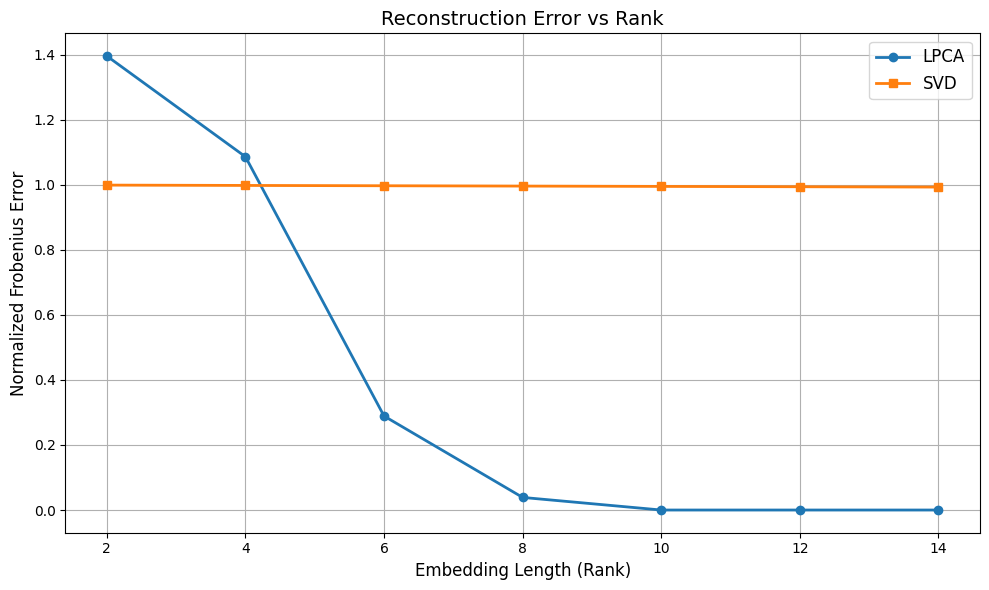

In [ ]:
ranks = list(range(2, 15 , 2))
err_list_lpca = []
err_list_svd = []
A = create_triangle_cycle(1000).astype(float)
eps = 1e-8
analyze_graph(A)

denom=norm(A, ord='fro')
for rank in ranks:
    # --- LPCA ---
    if rank>2 and err_list_lpca[-1]==0.:
      err_list_lpca.append(0.)
    else:
      P_lpca = lpca(A, rank)
      np.fill_diagonal(P_lpca, 0.)
      A_sampled_lpca = sample_adjacency_from_probs(P_lpca)
      err = norm(A_sampled_lpca - A, ord='fro') / denom
      err_list_lpca.append(err)

    # --- SVD ---
    X=np.clip(svd(A, rank),0.,1.)
    np.fill_diagonal(X, 0.)
    # P_svd = np.clip(svd(A, rank),eps,1.-eps)
    # A_sampled_svd = sample_adjacency_from_probs(P_svd)
    err = norm(X - A, ord='fro') / denom
    err_list_svd.append(err)
    print(f"Rank: {rank}, LPCA Error: {err_list_lpca[-1]}, SVD Error: {err_list_svd[-1]}")

# --- Plotting ---

plt.figure(figsize=(10, 6))
plt.plot(ranks, err_list_lpca, marker='o', label='LPCA', linewidth=2)
plt.plot(ranks, err_list_svd, marker='s', label='SVD', linewidth=2)
plt.title('Reconstruction Error vs Rank', fontsize=14)
plt.xlabel('Embedding Length (Rank)', fontsize=12)
plt.ylabel('Normalized Frobenius Error', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def plot_adjacency_comparison(original_adj, reconstructed_adj, title_suffix=""):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].imshow(original_adj, cmap=cm.Greys, interpolation='none')
    axs[0].set_title(f"Original Adjacency {title_suffix}")

    axs[1].imshow(reconstructed_adj, cmap=cm.Greys, interpolation='none')
    axs[1].set_title(f"Reconstructed by BigClam {title_suffix}")

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Experiment 2 : BIGCLAM failing when there is heterphilic interaction between communities.

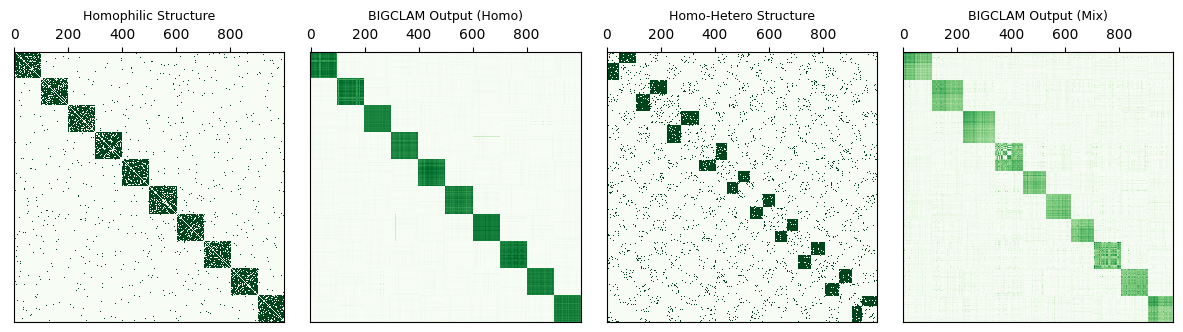

In [ ]:
A = create_sbm([100, 100, 100,100,100,100,100,100,100,100], p_in=0.8, p_out=0.01)
adj = sp.sparse.csr_matrix(A)
P = get_bigclam_approx(adj, 20, loss_iters=200, reg_l2=1e0, eps=1e-8, return_factors=False, verbose=False)
A_ = make_het_hom_graph(n=1000, het_probs=np.ones(2)/2, hom_probs=np.ones(10)/10)
adj_ = sp.sparse.csr_matrix(A_)
P_ = get_bigclam_approx(adj_, 20, loss_iters=200, reg_l2=1e0, eps=1e-8, return_factors=False, verbose=False)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3.2), dpi=100)

axes[0].matshow(A, vmin=0, vmax=1, cmap='Greens')
axes[0].set_title('Homophilic Structure', fontsize=9)

axes[1].matshow(P, vmin=0, vmax=1, cmap='Greens')
axes[1].set_title('BIGCLAM Output (Homo)', fontsize=9)

axes[2].matshow(A_, vmin=0, vmax=1, cmap='Greens')
axes[2].set_title('Homo-Hetero Structure', fontsize=9)

axes[3].matshow(P_, vmin=0, vmax=1, cmap='Greens')
axes[3].set_title('BIGCLAM Output (Mix)', fontsize=9)

for ax in axes:
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.tight_layout()
plt.show()


Experiment 3: AR decomposition vs for disconected cliques

Running for rank = 1
AR Reconstruction Error: 0.9486832980505139
SVD Reconstruction Error: 0.9486885684986407
Running for rank = 2
AR Reconstruction Error: 0.8944271909999165
SVD Reconstruction Error: 0.8944383712699271
Running for rank = 3
AR Reconstruction Error: 0.8366600265340761
SVD Reconstruction Error: 0.8366779547711294
Running for rank = 4
AR Reconstruction Error: 0.7745966692414857
SVD Reconstruction Error: 0.7746224887001409
Running for rank = 5
AR Reconstruction Error: 0.7071067811865501
SVD Reconstruction Error: 0.7071421356417675
Running for rank = 6
AR Reconstruction Error: 0.6324555320336788
SVD Reconstruction Error: 0.6325029644199306
Running for rank = 7
AR Reconstruction Error: 0.5477225575051694
SVD Reconstruction Error: 0.5477864547430868
Running for rank = 8
AR Reconstruction Error: 0.4472135954999636
SVD Reconstruction Error: 0.44730302927657445
Running for rank = 9
AR Reconstruction Error: 0.31622776601685126
SVD Reconstruction Error: 0.31637003650788426
Running

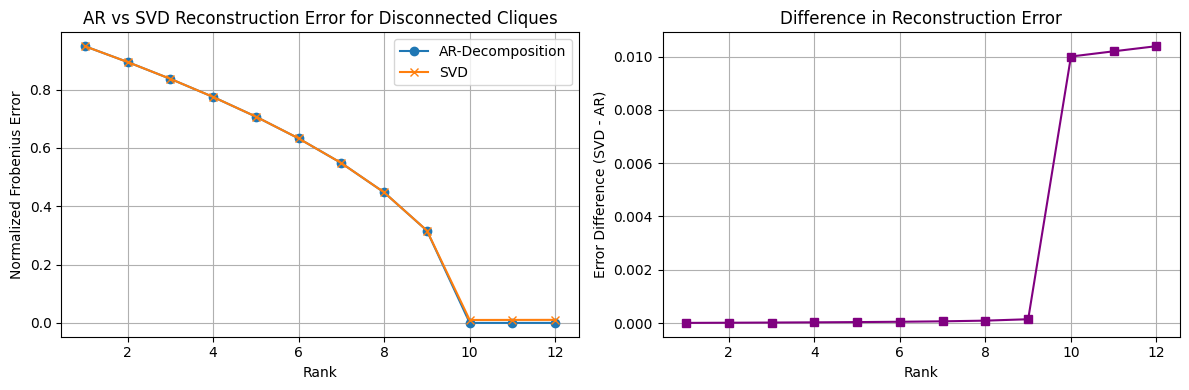

In [ ]:
def compare_ar_vs_svd_curve(adj_matrix, rank_list, ar_function):
    A_dense = adj_matrix.toarray()
    denom = norm(A_dense, 'fro')
    err_list_ar = []
    err_list_svd = []
    for k in rank_list:
        print(f"Running for rank = {k}")
        # --- AR Reconstruction ---
        A_ar = minimal_ar_decomposition(adj_matrix, k=k, return_factors=False)
        err_ar = norm(A_ar - A_dense, 'fro') / denom
        err_list_ar.append(err_ar)
        print(f"AR Reconstruction Error: {err_ar}")
        # --- SVD Reconstruction ---
        A_svd=svd(A_dense, k)
        err_svd = norm(A_svd - A_dense, 'fro') / denom
        err_list_svd.append(err_svd)
        print(f"SVD Reconstruction Error: {err_svd}")

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    # Plot reconstruction errors
    axs[0].plot(rank_list, err_list_ar, marker='o', label="AR-Decomposition")
    axs[0].plot(rank_list, err_list_svd, marker='x', label="SVD")
    axs[0].set_xlabel("Rank")
    axs[0].set_ylabel("Normalized Frobenius Error")
    axs[0].set_title("AR vs SVD Reconstruction Error for Disconnected Cliques")
    axs[0].legend()
    axs[0].grid(True)

    # Plot error difference (SVD - AR)
    error_diff = [svd - ar for svd, ar in zip(err_list_svd, err_list_ar)]
    axs[1].plot(rank_list, error_diff, marker='s', color='purple')
    axs[1].set_xlabel("Rank")
    axs[1].set_ylabel("Error Difference (SVD - AR)")
    axs[1].set_title("Difference in Reconstruction Error")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


X= generate_disconnected_cliques(10,100)
adj=sp.sparse.csr_matrix(X)
rank_range = list(range(1, 13,1))
compare_ar_vs_svd_curve(adj, rank_range, minimal_ar_decomposition)


Experiment 4: AR decomposition vs for SBM

Running for rank = 1
AR Reconstruction Error: 0.9545320106311268
SVD Reconstruction Error: 0.954529139683763
Running for rank = 2
AR Reconstruction Error: 0.9161214502829228
SVD Reconstruction Error: 0.9161197315767198
Running for rank = 3
AR Reconstruction Error: 0.8763474026724813
SVD Reconstruction Error: 0.87634773979466
Running for rank = 4
AR Reconstruction Error: 0.8346450984951292
SVD Reconstruction Error: 0.8346575604362927
Running for rank = 5
AR Reconstruction Error: 0.7908945449486519
SVD Reconstruction Error: 0.7908907674007535
Running for rank = 6
AR Reconstruction Error: 0.7446706639260032
SVD Reconstruction Error: 0.7446870838883457
Running for rank = 7
AR Reconstruction Error: 0.6954526756395547
SVD Reconstruction Error: 0.6955145317665167
Running for rank = 8
AR Reconstruction Error: 0.6427346702076677
SVD Reconstruction Error: 0.6427845336755142
Running for rank = 9
AR Reconstruction Error: 0.5858982142113462
SVD Reconstruction Error: 0.5859006337771349
Running for r

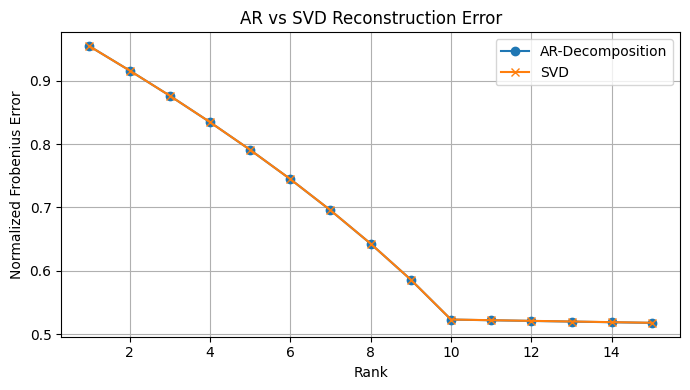

In [ ]:
def compare_ar_vs_svd_curve(adj_matrix, rank_list, ar_function):
    A_dense = adj_matrix.toarray()

    denom = norm(A_dense, 'fro')

    err_list_ar = []
    err_list_svd = []
    for k in rank_list:
        print(f"Running for rank = {k}")

        # --- AR Reconstruction ---
        A_ar = minimal_ar_decomposition(adj_matrix, k=k, return_factors=False)
        err_ar = norm(A_ar - A_dense, 'fro') / denom
        err_list_ar.append(err_ar)
        print(f"AR Reconstruction Error: {err_ar}")

        # --- SVD Reconstruction ---
        A_svd=svd(A_dense, k)
        # np.fill_diagonal(A_svd, 0.0)
        err_svd = norm(A_svd - A_dense, 'fro') / denom
        err_list_svd.append(err_svd)
        print(f"SVD Reconstruction Error: {err_svd}")

   # --- Plot only reconstruction errors ---
    plt.figure(figsize=(7, 4))
    plt.plot(rank_list, err_list_ar, marker='o', label="AR-Decomposition")
    plt.plot(rank_list, err_list_svd, marker='x', label="SVD")
    plt.xlabel("Rank")
    plt.ylabel("Normalized Frobenius Error")
    plt.title("AR vs SVD Reconstruction Error for SBM")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

X=create_sbm([100, 100, 100,100,100,100,100,100,100,100], p_in=0.8, p_out=0.01)
adj=sp.sparse.csr_matrix(X)
rank_range = list(range(1,16,1))
compare_ar_vs_svd_curve(adj, rank_range, minimal_ar_decomposition)


Experiment 5: Interpretability of decomposition

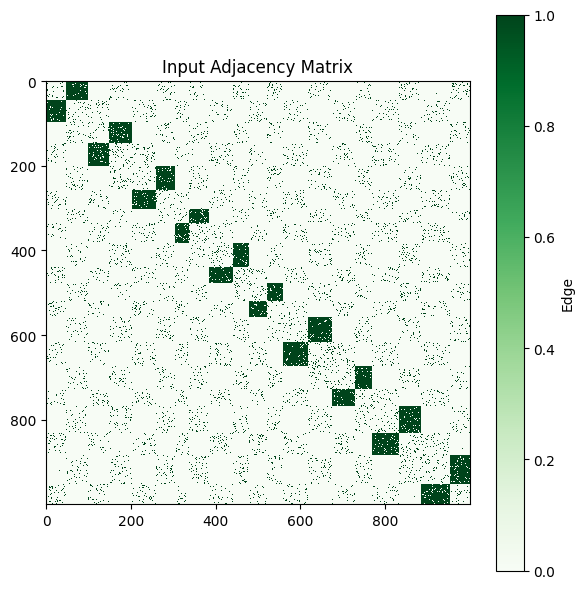

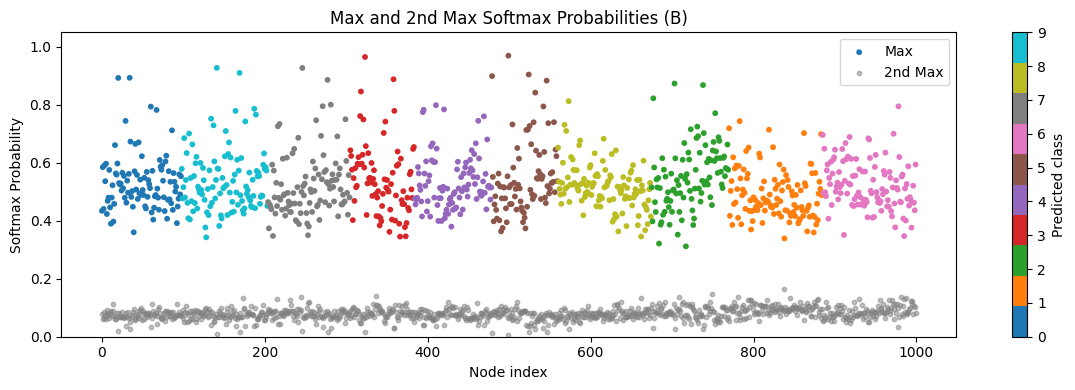

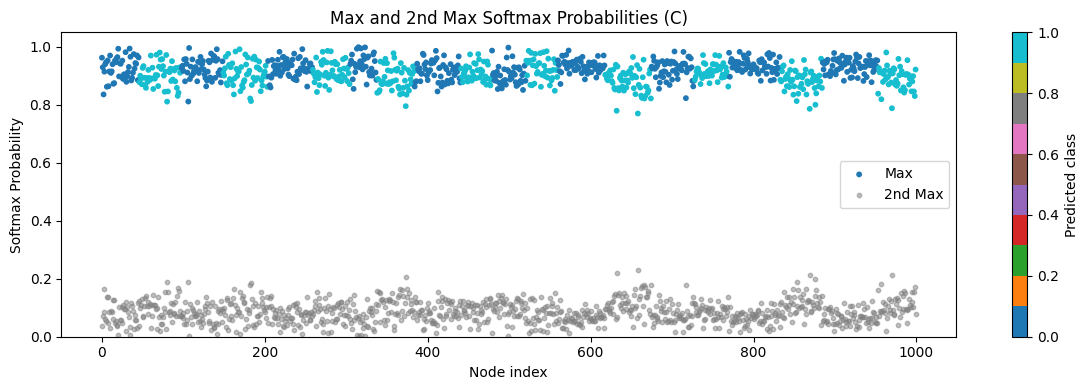

In [ ]:
A = make_het_hom_graph(n=1000, het_probs=np.ones(2)/2, hom_probs=np.ones(10)/10)
adj = sp.sparse.csr_matrix(A)
adj_recon, B, C, base_logit = DSNE(adj, B_rank=10, C_rank=2, return_factors=True)
plot_softmax_distributions(adj,B, C)


Experiment 6: Limitations of interpreatability with varying community size

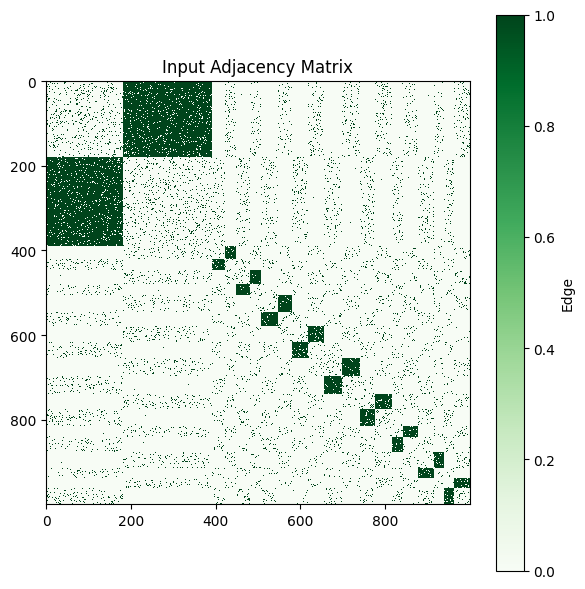

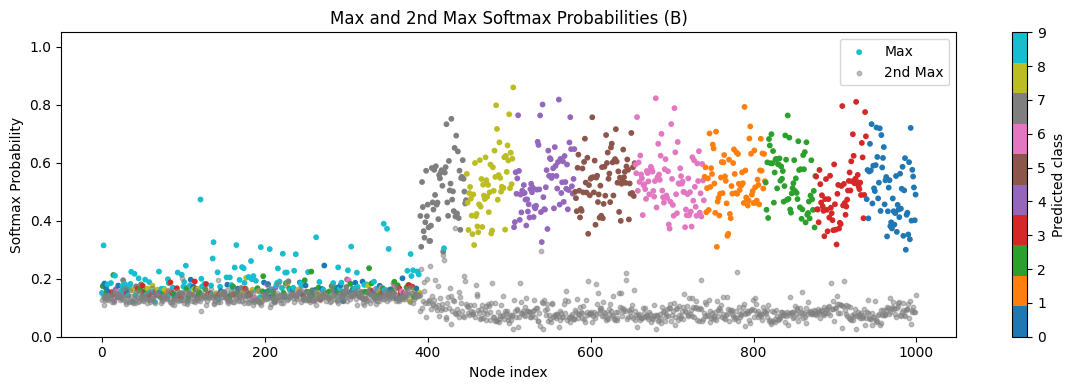

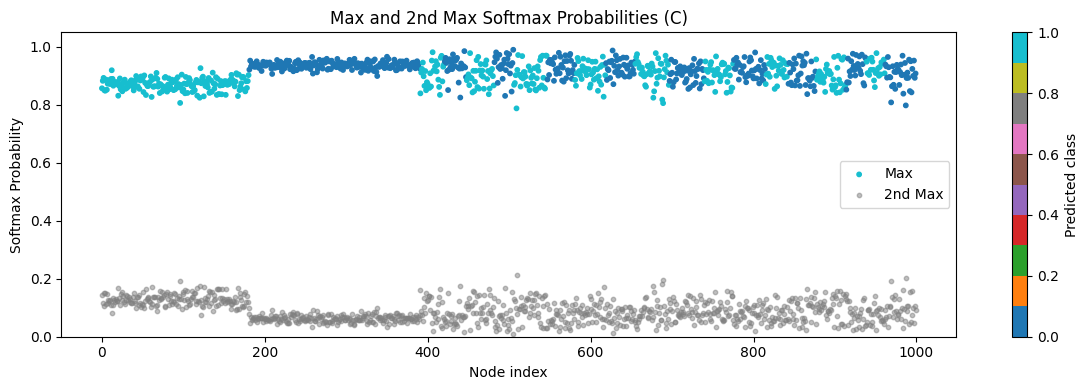

In [ ]:
A= make_het_hom_graph(n=1000, het_probs=np.ones(2)/2, hom_probs = np.array([0.4, 0.05, 0.05, 0.08, 0.08, 0.08, 0.08, 0.06, 0.06, 0.06]))
adj = sp.sparse.csr_matrix(A)
adj_recon, B, C, base_logit = DSNE(adj, B_rank=10, C_rank=2, return_factors=True)
plot_softmax_distributions(adj,B, C)

Experiment 7: Limitations of interpreatability with varying heterophily

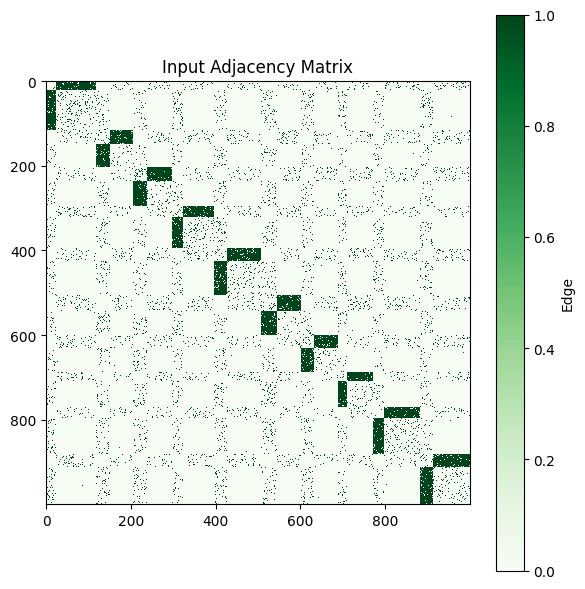

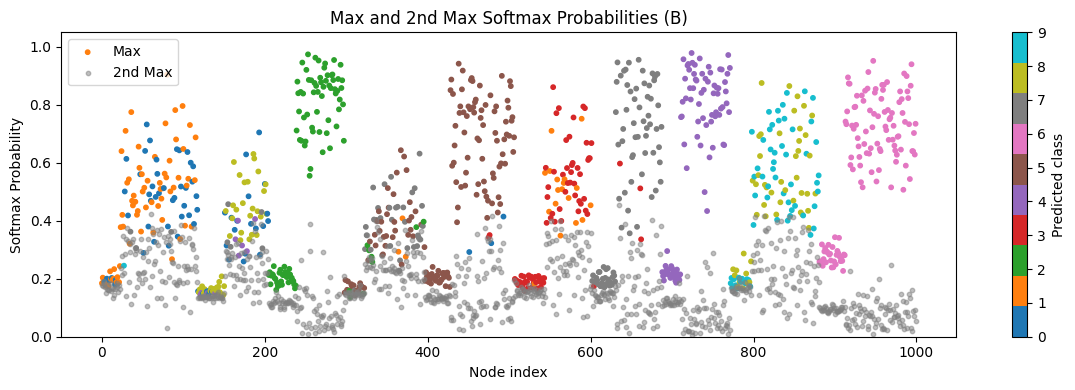

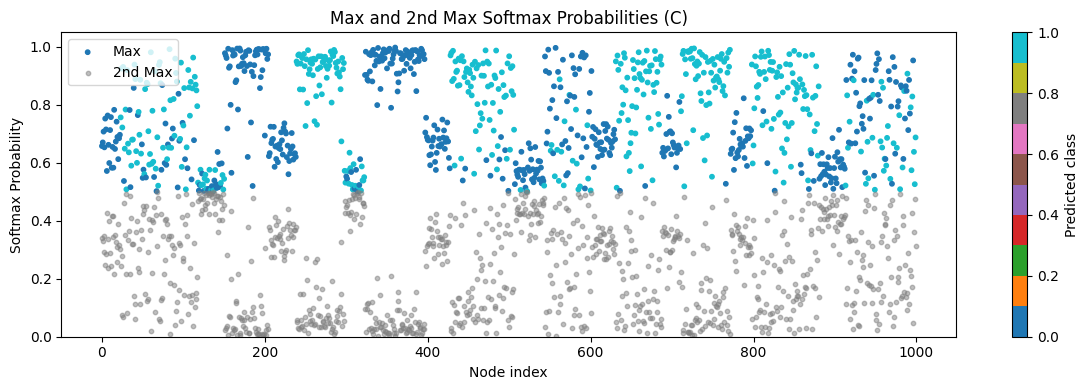

In [ ]:
A= make_het_hom_graph(n=1000, het_probs=np.array([0.3,0.7]), hom_probs = np.ones(10)/10)
adj = sp.sparse.csr_matrix(A)
adj_recon, B, C, base_logit = DSNE(adj, B_rank=10, C_rank=2, return_factors=True)
plot_softmax_distributions(adj,B, C)

Experiment 8: Varying Both community size and heterophility results in no interpretability

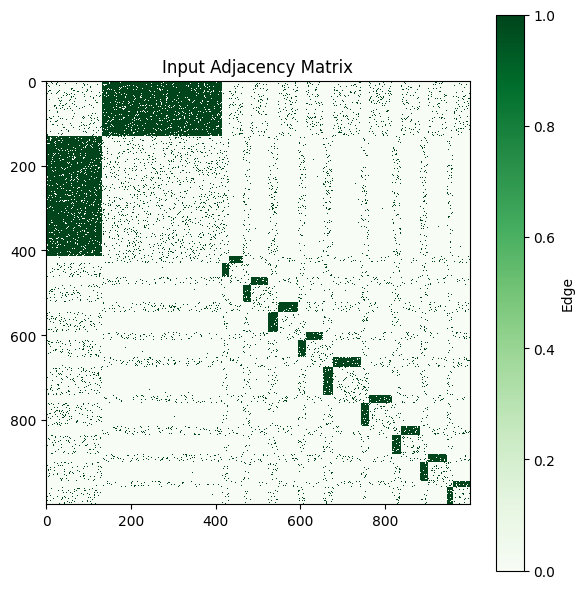

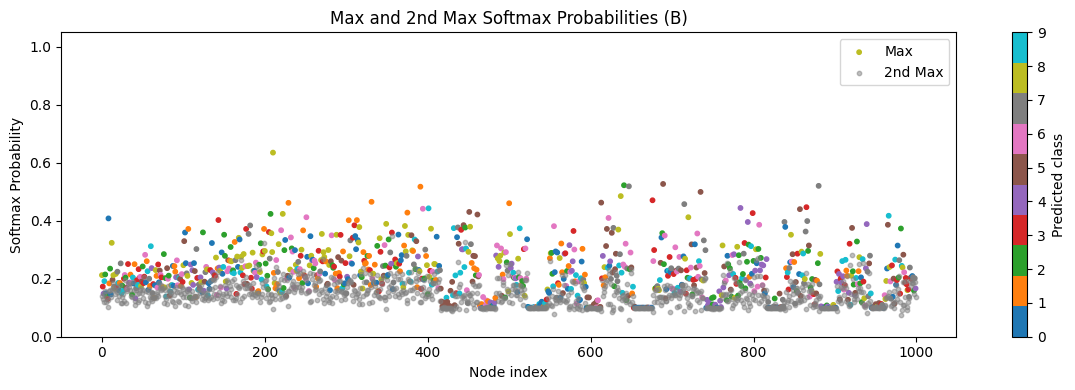

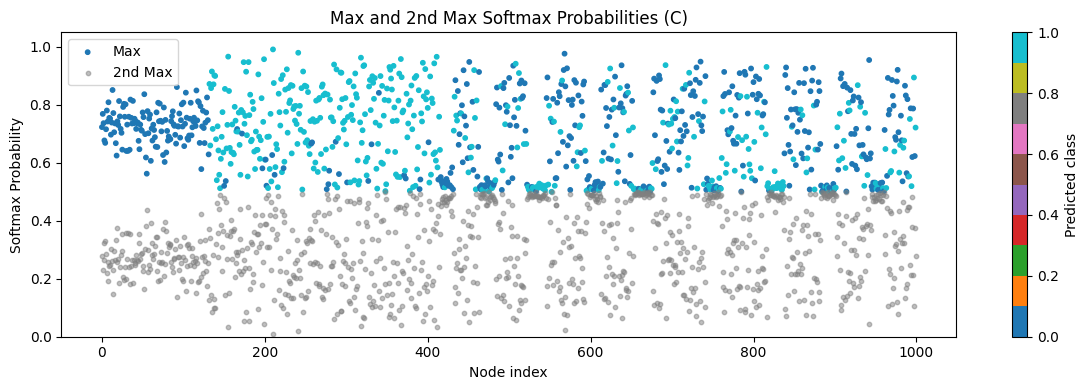

In [ ]:
A= make_het_hom_graph(n=1000, het_probs=np.array([0.3,0.7]),  hom_probs = np.array([0.4, 0.05, 0.05, 0.08, 0.08, 0.08, 0.08, 0.06, 0.06, 0.06]))
adj = sp.sparse.csr_matrix(A)
adj_recon, B, C, base_logit = DSNE(adj, B_rank=10, C_rank=2, return_factors=True)
plot_softmax_distributions(adj,B, C)